In [1]:
from pycalphad import Database, Model, variables as v
from pycalphad.core.solver import Solver
from pycalphad.codegen.callables import build_phase_records
from pycalphad.core.utils import instantiate_models
from pycalphad.codegen.sympydiff_utils import build_functions
from pycalphad.core.composition_set import CompositionSet
from pycalphad.core.minimizer import state_variable_differential, site_fraction_differential
import numpy as np
dbf = Database('alfe_sei.TDB')
comps = ['AL', 'FE', 'VA']
mod = Model(dbf, comps, 'B2_BCC')
starting_temp = float(1000)
state_variables = {v.N, v.P, v.T}
models = instantiate_models(dbf, comps, ['B2_BCC'])
phase_records = build_phase_records(dbf, comps, ['B2_BCC'], state_variables, models)
compset = CompositionSet(phase_records['B2_BCC'])
compset.update(np.array([0.56819794, 0.43180206, 0.03180206, 0.96819794, 1]), 1.0, np.array([1, 1e5, starting_temp]))
compsets = [compset]
solver = Solver()
spec = solver.get_system_spec(compsets, {'N': 1, 'T': starting_temp, 'P': 1e5, 'X_AL': 0.3})
state = spec.get_new_state(compsets)
converged = spec.run_loop(state, 1000)
if converged:
    # TODO: Check example in https://github.com/pycalphad/pycalphad/issues/261
    property_of_interest = 'HM'
    statevar_of_interest = v.T
    statevar_idx = sorted(state_variables, key=str).index(statevar_of_interest)
    delta_chemical_potentials, delta_statevars, delta_phase_amounts = \
    state_variable_differential(spec, state, statevar_idx)
    print('delta_chempots', delta_chemical_potentials)
    print('delta_statevars', delta_statevars)
    print('delta_phase_amounts', delta_phase_amounts)
    property_records = {}
    unique_phases = sorted(set(compset.phase_record.phase_name for compset in compsets))
    for phase_name in unique_phases:
        property_records[phase_name] = build_functions(getattr(models[phase_name], property_of_interest),
                                        sorted(state_variables, key=str) + models[phase_name].site_fractions,
                                        include_grad=True)
    # Sundman et al, 2015, Eq. 73
    dot_derivative = 0.0
    naive_derivative = 0.0
    for idx, compset in enumerate(compsets):
        phase_name = compset.phase_record.phase_name
        proprecord = property_records[phase_name]
        func_value, grad_value = proprecord.func(compset.dof), proprecord.grad(compset.dof)
        delta_sitefracs = site_fraction_differential(state.cs_states[idx], delta_chemical_potentials,
                                                     delta_statevars)
       
        print('delta_sitefracs', delta_sitefracs)
        dot_derivative += delta_phase_amounts[idx] * func_value
        dot_derivative += compset.NP * grad_value[statevar_idx] * delta_statevars[statevar_idx]
        naive_derivative += compset.NP * grad_value[statevar_idx] * delta_statevars[statevar_idx]
        dot_derivative += compset.NP * np.dot(delta_sitefracs, grad_value[len(state_variables):])
    print('Dot Derivative', dot_derivative)
    print('Naive Derivative', naive_derivative)


delta_chempots [-51.92141503 -72.21540615]
delta_statevars [0. 0. 1.]
delta_phase_amounts [6.93117183e-21]
delta_sitefracs [-1.61908561e-04  1.61908561e-04  1.61908561e-04 -1.61908561e-04
  1.24143851e-20]
Dot Derivative 36.64854055395234
Naive Derivative 34.164547639869525


In [2]:
from pycalphad import Database, Model, variables as v
from pycalphad.core.solver import Solver
from pycalphad.codegen.callables import build_phase_records
from pycalphad.core.utils import instantiate_models
from pycalphad.codegen.sympydiff_utils import build_functions
from pycalphad.core.composition_set import CompositionSet
from pycalphad.core.minimizer import state_variable_differential, site_fraction_differential
import numpy as np
from pycalphad.core.equilibrium import dot_derivative

dbf = Database('alfe_sei.TDB')
comps = ['AL', 'FE', 'VA']
mod = Model(dbf, comps, 'B2_BCC')
starting_temp = float(1000)
state_variables = {v.N, v.P, v.T}
models = instantiate_models(dbf, comps, ['B2_BCC'])
phase_records = build_phase_records(dbf, comps, ['B2_BCC'], state_variables, models)
compset = CompositionSet(phase_records['B2_BCC'])
compset.update(np.array([0.56819794, 0.43180206, 0.03180206, 0.96819794, 1]), 1.0, np.array([1, 1e5, starting_temp]))
compsets = [compset]
solver = Solver()
spec = solver.get_system_spec(compsets, {'N': 1, 'T': starting_temp, 'P': 1e5, 'X_AL': 0.3})
state = spec.get_new_state(compsets)
converged = spec.run_loop(state, 1000)
property_records = {}
unique_phases = sorted(set(compset.phase_record.phase_name for compset in compsets))
for phase_name in unique_phases:
    property_records[phase_name] = build_functions(getattr(models[phase_name], property_of_interest),
                                        sorted(state_variables, key=str) + models[phase_name].site_fractions,
                                        include_grad=True)

#testing the function results
dot_derivative(spec, state, property_records)


34.164547639869525

In [3]:
import pycalphad
pycalphad.__file__

'c:\\users\\aliciaxz\\pycalphad\\pycalphad\\__init__.py'

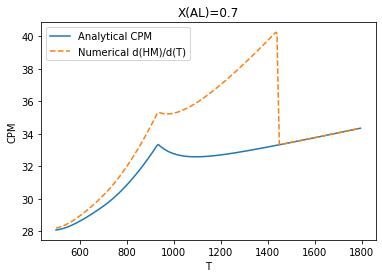

In [7]:
from pycalphad import Database, equilibrium, variables as v
from numpy import broadcast_to
import numpy as np
import matplotlib.pyplot as plt

dbf = Database('alfe_sei.TDB')
#equilibrium(..., output='H.T')
# Plot CPM vs. T
eq_T = equilibrium(dbf, ['AL', 'FE', 'VA'], 'B2_BCC', {v.P:101325, v.N: 1, v.T: (500, 1800, 5),
 v.X('AL'): 0.7}, calc_opts={'pdens': 5_000}, output=['heat_capacity', 'HM'])
# Perform numerical derivative
numerical_CPM = np.gradient(eq_T.HM.values.squeeze(), eq_T.T.values.squeeze())
# Plot
plt.plot(eq_T.T, eq_T.heat_capacity.values.squeeze(), label='Analytical CPM')
plt.plot(eq_T.T, numerical_CPM, label='Numerical d(HM)/d(T)', ls='--')
plt.ylabel('CPM')
plt.xlabel('T')
plt.title('X(AL)=0.7')
plt.legend()
plt.show()